# Probando!!!

In [1]:
import medmnist, torch
import numpy as np
from medmnist import INFO, Evaluator
from medmnist.dataset import PneumoniaMNIST
import torch.utils.data as data

import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


Using downloaded and verified file: data/pneumoniamnist.npz
AnomalyPneumoniaMNIST Dataset (Number of samples: 1395, Number of known anomalies: 121, Number of unknown anomalies: 60)


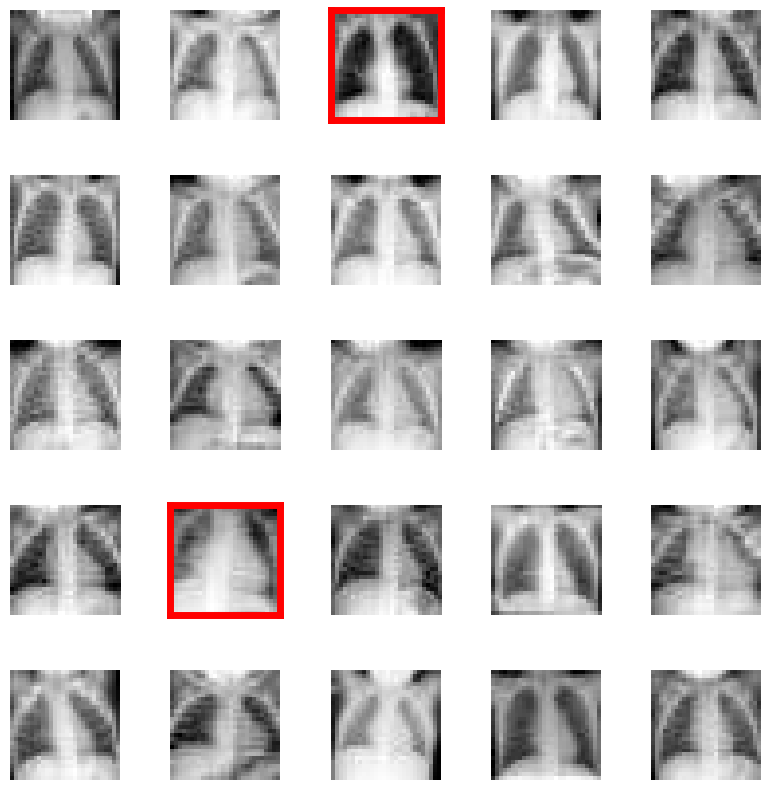

In [2]:
from dataset import AnomalyPneumoniaMNIST
from matplotlib import pyplot as plt
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# Load the dataset
seed = 42
train_dataset = AnomalyPneumoniaMNIST('data/', download=True, transform=data_transform, n_normal_samples=-1, known_anomalies=0.1, pollution=0.05, seed=seed)
print(train_dataset)

train_dataset.montage(5, 5, seed)
plt.show()

In [3]:
# Generate the test dataset and the loaders
BATCH_SIZE = 128
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True, root='data/')

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: data/pneumoniamnist.npz


In [4]:
test_dataset.labels

array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
    

# Model

In [5]:
from ADeLEn.model import ADeLEn
from torch.nn.functional import mse_loss
from VAE.loss import SGVBL

# model = ADeLEn((28, 28), [1, 12, 32], [1024, 512, 128, 2], skip_connection=False) # Old implementation
d = 2
model = ADeLEn((28, 28), [1, 16, 24], [1024, 256, 32], bottleneck=d, skip_connection=False)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(train_dataset), mle=mse_loss)

# Training

In [ ]:
def _weights(dataset):
    import numpy as np
    _, y = zip(*dataset)
    y = torch.tensor(y)

    count = torch.bincount(y)
    weights = 1. / np.array(count)
    weights /= weights.sum()

    return weights[y]

def train(model, dataset, batch_size, n_epochs, lr=1e-3, kl_weight=1, weighted_sampler=False):
    from tqdm import tqdm
    from torch.utils.data import DataLoader
    from torch.optim import Adam
    
    if weighted_sampler:
        sampler = torch.utils.data.WeightedRandomSampler(_weights(dataset), len(dataset), replacement=True)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    opt = Adam(model.parameters(), lr=lr)

    for _ in epoch_iterator:
        epoch_loss = 0.
        for x, y in train_loader:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = torch.tanh(model(x))
            loss = sgvbl(x, x_hat, y, kl_weight)
            epoch_loss += loss.detach().item()

            loss.backward()
            opt.step()

        epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

    return model.eval().cpu()

In [ ]:
model = train(model, train_dataset, BATCH_SIZE, 100, lr=1e-3, kl_weight=1, weighted_sampler=False)

# Result

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def plot_latent(model, data, num_batches=100):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            x = x
            z = model.bottleneck(model.encode_path(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

In [ ]:
train_eval_loader = data.DataLoader(dataset=train_dataset, batch_size=4*BATCH_SIZE, shuffle=False)
plot_latent(model, train_eval_loader, num_batches=1)

In [ ]:
x, y = next(iter(train_loader))
x_0 = x[np.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[np.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)
x = torch.cat([x_0, x_1], dim=0)
# _ = model.bottleneck(model.encoder(x.to(device)))
_ = model(x)

# mu, sigma = model.bottleneck[1].anomaly_detector.mu.detach().cpu(), model.bottleneck[1].anomaly_detector.sigma.detach().cpu()
mu, sigma = model.bottleneck.mu.detach().cpu(), model.bottleneck.sigma.detach().cpu()

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title("Normal", fontsize='x-large')
plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[0].numpy().tolist(), *sigma[0].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[0][0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Anomaly", fontsize='x-large')
plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[1].numpy().tolist(), *sigma[1].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[1][0], cmap='gray')

plt.savefig('figures/medmnist_test.pdf', bbox_inches='tight')
plt.show()

x = torch.cat([x_0, x_1])
# z = model.bottleneck(model.encoder(x.to(device))).detach().cpu()
mu, sigma

In [ ]:
x_hat = model(x_0)
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1)
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

mse_loss(x_hat, x_0), mse_loss(x_hat, x_1)


In [ ]:
import numpy as np
# def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
#     w = 28
#     img = np.zeros((n*w, n*w))

#     bottleneck, unflatten = autoencoder.bottleneck[1:]
#     bottleneck = bottleneck.bottleneck[2]

#     for i, y in enumerate(np.linspace(*r1, n)):
#         for j, x in enumerate(np.linspace(*r0, n)):
#             z = torch.Tensor([[x, y]]).to(device)
#             x_hat = torch.tanh(autoencoder.decoder(unflatten(bottleneck(z)))) # ADeLEn
#             # x_hat = torch.tanh(autoencoder.decoder(z))
#             x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
#             img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
#     plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
#     plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
#     plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

def plot_reconstructed(model, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = torch.tanh(model.decode_path(z)) # ADeLEn
            # x_hat = torch.tanh(autoencoder.decoder(z))
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
    plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

In [ ]:
plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=12)

# Test

In [ ]:
x_test, y_test = next(iter(test_loader))
print(x_test.shape)
# x_0 = x_test[np.argwhere(y_test==0)[0].squeeze()[:100]]
# x_1 = x_test[np.argwhere(y_test==1)[0].squeeze()[:100]]
x_0 = x_test[np.argwhere(y_test==0)[0].squeeze()]
x_1 = x_test[np.argwhere(y_test==1)[0].squeeze()]

x = torch.cat([x_0, x_1], dim=0)
y = torch.cat([torch.zeros(len(x_0)), torch.ones(len(x_1))])

x_enc = model.encode_path(x)
# x_enc, sk = model.encoder(x.to(device))
# flatten, bottleneck, unflatten = model.bottleneck[:3]
# bottleneck = bottleneck.bottleneck[:2]
x_bottleneck = model.bottleneck(x_enc)

anomaly_detector = model.bottleneck
sigma = anomaly_detector.sigma.detach().cpu()
sigma.mean(axis=0), sigma.std(axis=0)

In [ ]:
sigma[:100].mean(axis=0), sigma[100:].mean(axis=0)

In [ ]:
import numpy as np
x_test, y_test = list(zip(*[(_x, _y) for _x, _y in test_dataset]))
x_test = torch.tensor(np.stack(x_test))
y_test = torch.tensor(y_test).flatten()

_ = model(x_test)

In [ ]:
model.eval()
y_score = model.score_samples(x_test)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
plt.hist(y_score[torch.argwhere(y_test==0).squeeze()], bins=10, alpha=.5, label='normal')
plt.hist(y_score[torch.argwhere(y_test==1).squeeze()], bins=10, alpha=.5, label='anomaly')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def threshold(sigma, d) -> float:
        score = d*np.log(sigma)
        gauss = d * np.log(2*torch.pi*torch.e)
        return .5 * (gauss + score)

threshold(1.2, d=d)

In [ ]:
y_pred = np.zeros_like(y_score)
y_pred[y_score > threshold(1.2, d=d)] = 1

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

# Experiment

In [6]:
from experiments.MedMNIST import ExperimentADeLEn

In [7]:
exp = ExperimentADeLEn(.2, 0)

Using downloaded and verified file: data/pneumoniamnist.npz
Using downloaded and verified file: data/pneumoniamnist.npz


In [8]:
exp.run()

0.9342318650010957

In [9]:
exp.classification_metrics()

(0.8766025641025641, 0.856492027334852, 0.9641025641025641, 0.9071170084439083)

In [11]:
config = exp.config()
config

{'experiment_name': 'ADeLEn/2/medmnist_anomalies_0.2_pollution_0',
 'dataset_dir': './data/',
 'model': ADeLEn(
   (encode_path): Sequential(
     (0): ConvEncoder(
       (encode_path): Sequential(
         (0): Sequential(
           (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): Dropout2d(p=0.2, inplace=False)
           (3): ReLU()
           (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
         )
         (1): Sequential(
           (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): Dropout2d(p=0.2, inplace=False)
           (3): ReLU()
           (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
         )
       )
     )
     (1): Flatten(start_dim=1, e

In [ ]:
X, y = zip(*exp.test_dataset)
X = torch.stack(X)
y = torch.tensor(np.array(y).flatten())

y.shape, X.shape

In [ ]:
from experiments.MNIST import ExperimentADeLEn
exp = ExperimentADeLEn(.1, 0)
X, y = zip(*exp.test_dataset)
X = torch.stack(X)
y = torch.tensor(y)
y.shape, X.shape